# Joint project AMD + SM2L

https://docs.google.com/document/d/1oqoIyRUI_digfIokf53fox0I1eWiTFzQaae-PxMre0Y/edit

The task is to implement from scratch a learning algorithm for **regression** with **square loss** (e.g., **ridge regression**). The label to be predicted must be selected among the following 5 attributes, removing the remaining 4 from the dataset:
- PERNP (Person's earnings)
- PINCP (Person's income)
- WAGP (Wages or salary income past 12 months)
- HINCP (Household income)
- FINCP (Family income)

This code is run inside the Docker container provided in the course.

## Dataset

In [1]:
from pyspark import SparkContext
from pyspark.sql import SQLContext

sc = SparkContext('local[*]')
sqlContext = SQLContext(sc)

In [23]:
import os, zipfile, json
import numpy as np
from pyspark.sql.functions import udf, isnan, when, count, col, mean, stddev
from pyspark.sql.types import DoubleType
from pyspark.ml import Pipeline
from pyspark.ml.feature import MinMaxScaler, StandardScaler, VectorAssembler, Imputer, PCA
from pyspark.mllib.regression import LabeledPoint

def install_kaggle():
    """
    Installs and setups Kaggle API, that are needed in order to download the dataset.
    """
    
    os.system('pip install --user kaggle')
        
    os.environ["PATH"] += os.pathsep + "/home/jovyan/.local/bin"
    
    os.system('mkdir ~/.kaggle')
    os.system("""echo '{"username":"teresatanzi","key":"a64ec0d865925975d3318adf576216b7"}' >> ~/.kaggle/kaggle.json""")
    os.system('chmod 600 ~/.kaggle/kaggle.json')
    
    os.environ["KAGGLE_USERNAME"] = "teresatanzi"
    os.environ["KAGGLE_KEY"] = "a64ec0d865925975d3318adf576216b7"

def download_dataset(path):
    """
    Checks if the dataset has already been downloaded and, if not, downloads and unzips it.
    """
    
    if (os.path.exists('./data/2013-american-community-survey/ss13husa.csv') and
        os.path.exists('./data/2013-american-community-survey/ss13husb.csv') and 
        os.path.exists('./data/2013-american-community-survey/ss13pusa.csv') and
        os.path.exists('./data/2013-american-community-survey/ss13pusb.csv')):
        print('Data already downloaded.')
        return

    # setup Kaggle API
    print('Installing Kaggle API...')
    install_kaggle()
    
    # dataset download
    print('Downloading the dataset...')
    os.system('mkdir ./data')
    os.system('kaggle datasets download census/2013-american-community-survey -p ./data')

    print('Unzipping the dataset...')
    with zipfile.ZipFile("./data/2013-american-community-survey.zip","r") as zip_ref:
        zip_ref.extractall(path)

    print('DONE! Data have been extracted in dir {}.'.format(path))

def preprocess (train_df, test_df, val_df, na_threshold, label, n_features, imputer_strategy = 'mean'):
    """
    Preprocess a PySpark DataFrame, dropping the categorical feature and the discarded labels,
        casting the remaining features in double, dealing with null values with imputation and 
        dropping the features with too many missing values, dropping also all the data points
        with missing label. Optionally, scales all the features of the DataFrame.
        
    Note:
        Feature scaling can slow up the process if the DataFrame is huge.

    Args:
        train_df (PySpark DataFrame): portion of the DataFrame read by the csv file, corresponding to the
            training set.
        test_df (PySpark DataFrame): portion of the DataFrame read by the csv file, corresponding to the test
            set.
        val_df (PySpark DataFrame): portion of the DataFrame read by the csv file, corresponding to the
            validation set.
        na_threshold (float between 0 and 1): threshold that establish if a feature should be dropped or not
            based on its percentage of null values.
        label (string): feature that corresponds to the chosen label to be predicted.
        n_features (int): number of features we want to obtain after we apply the PCA dimensionality reduction
            strategy.
        imputer_strategy (string): it can be `mean` or `median`, based on the imputation strategy we choose.
        feature_scaling (boolean): if True, all the feature in the DataFrame are scaled to have values belonging
            in intervall [0, 1], but it slows the process.

    Returns:
        PySpark DataFrame: Restult of the processing of the original DataFrame.
    """    
    
    print("Dropping features...")
    train_df = train_df.drop('RT')
    test_df = test_df.drop('RT')
    val_df = val_df.drop('RT')
    
    #possible_labels = ['PERNP', 'PINCP', 'WAGP'] if inputPathA == 'ss13pusa.csv' else ['HINCP', 'FINCP']     
    possible_labels = ['HINCP', 'FINCP']    
    possible_labels.remove(label)
    
    for i in possible_labels:
        train_df = train_df.drop(i)
        test_df = test_df.drop(i)
        val_df = val_df.drop(i)

    print("Casting features to double...")    
    train_df = train_df.select([col(c).cast("double") for c in train_df.columns])
    test_df = test_df.select([col(c).cast("double") for c in test_df.columns])
    val_df = val_df.select([col(c).cast("double") for c in val_df.columns])
    
    print('Dropping data points with null label...')
    train_df = train_df.filter(train_df[label].isNotNull()) 
    test_df = test_df.filter(test_df[label].isNotNull())
    val_df = val_df.filter(val_df[label].isNotNull())
    
    # we should save max and min label of the training set in order to convert back (if we use MinMaxScaler)
    row_max = train_df.agg({label: "max"}).collect()[0]
    row_min = train_df.agg({label: "min"}).collect()[0]
    max_lbl = row_max["max(" + label + ")"]
    min_lbl = row_min["min(" + label + ")"]
    print("{} stats:".format(label))
    print("\tMax {}: {}\n\tMin {}: {}".format(label, max_lbl, label, min_lbl))
        
    # we should save mean and standard deviation of the training set in order to convert back (if we use
    # StandardSacaler)
    df_stats = train_df.select(
        mean(col(label)).alias('mean'),
        stddev(col(label)).alias('std')
    ).collect()

    mean_lbl = df_stats[0]['mean']
    std_lbl = df_stats[0]['std']
    print("\tMean {}: {}\n\tSt. dev. {}: {}".format(label, mean_lbl, label, std_lbl))
    
    label_stats = dict()
    label_stats["min"] = min_lbl
    label_stats["max"] = max_lbl
    label_stats["mean"] = mean_lbl
    label_stats["std"] = std_lbl
        
    print("Dropping features with more than {}% null values...".format(int(na_threshold * 100)))
    n = train_df.count()
    null_df = train_df.select([(count(when(col(c).isNull(), c))/n).alias(c) for c in train_df.columns])
    
    scheme = train_df.columns
    null_distr = null_df.take(1)[0].asDict().values()
    
    for i in np.where(np.array(list(null_distr)) > na_threshold)[0]:
        train_df = train_df.drop(scheme[i])
        test_df = test_df.drop(scheme[i])
        val_df = val_df.drop(scheme[i])
        
    print('We reduced the number of features to {}.'.format(len(train_df.columns)))  

    print('Imputing missing values...')    
    imputer = Imputer()
    imputer.setInputCols(train_df.columns)
    imputer.setOutputCols(train_df.columns)
    imputer.setStrategy(imputer_strategy)

    imputer = imputer.fit(train_df)
    
    train_df = imputer.transform(train_df)
    test_df = imputer.transform(test_df)
    val_df = imputer.transform(val_df)
    
    print("Feature scaling...")
    columns = train_df.columns
    columns.remove(label)

    assembler = VectorAssembler(inputCols = columns, outputCol = 'features')
    transformed_train_df = assembler.transform(train_df).select(['features', label])
    transformed_test_df = assembler.transform(test_df).select(['features', label])
    transformed_val_df = assembler.transform(val_df).select(['features', label])
    
    assembler_lbl = VectorAssembler(inputCols = [label], outputCol = 'label')
    transformed_train_df = assembler_lbl.transform(transformed_train_df).select(['features', 'label'])
    transformed_test_df = assembler_lbl.transform(transformed_test_df).select(['features', 'label'])
    transformed_val_df = assembler_lbl.transform(transformed_val_df).select(['features', 'label'])
    
    scaler = StandardScaler(inputCol = 'features', outputCol = 'scaledFeatures').fit(transformed_train_df)
    transformed_train_df = scaler.transform(transformed_train_df)
    transformed_test_df = scaler.transform(transformed_test_df)
    transformed_val_df = scaler.transform(transformed_val_df)
    
    scaler_lbl = StandardScaler(inputCol = 'label', outputCol = 'scaledLabel').fit(transformed_train_df)
    transformed_train_df = scaler_lbl.transform(transformed_train_df)
    transformed_test_df = scaler_lbl.transform(transformed_test_df)
    transformed_val_df = scaler_lbl.transform(transformed_val_df)
    
    print('Applying PCA for dimensionality reduction...')
    pca = PCA(k = n_features, inputCol = 'scaledFeatures', outputCol = 'pcaFeatures').fit(transformed_train_df)
    transformed_train_df = pca.transform(transformed_train_df)
    transformed_test_df = pca.transform(transformed_test_df)
    transformed_val_df = pca.transform(transformed_val_df)
    print('Explained Variance Ratio\n', pca.explainedVariance.toArray())
    
    print('Transforming each data point in a LabeledPoint...')
    parsed_train_data = transformed_train_df.rdd.map(lambda s: parse_point(s))
    parsed_test_data = transformed_test_df.rdd.map(lambda s: parse_point(s))
    parsed_val_data = transformed_val_df.rdd.map(lambda s: parse_point(s))

    print("DONE!")
        
    return parsed_train_data, parsed_test_data, parsed_val_data, label_stats

def save_preprocessed_rdd(rdd, filename):
    """
    Saves the rdd on disk as a file.
    
    Note:
        This operation can be really slow. It should be done once and only in case of multiple executions
            of the learning code, in order to avoid to recompute the preprocessing every time.
    
    Args:
        rdd (PySpark RDD): RDD that has to be saved on disk.
        filename (String): Name of the file to be saved.
    """
    
    print("Saving preprocessed data...")
    base_dir = os.path.join('./data')
    input_path = os.path.join(filename)
    file_name = os.path.join(base_dir, input_path)

    rdd.saveAsTextFile(file_name)

def parse_line(line):
    """
    Converts one line of a saved preprocessed data file in a LabledPoint.
    
    Args: 
        line (String): A line of the file.
    
    Returns:
        LabeledPoint: LabeledPoint corresponding to the line in input.
    """
    
    label_value, feature_list = (line.strip()[1:-1]).split(',', 1)
    
    return LabeledPoint(float(label_value), [float(i) for i in feature_list[1:-1].split(',')])
    
def load_preprocessed_datasets():
    """
    Loads preprocessed data from disk.
    
    Returns:
        RDD of LabeledPoints: RDD containing the saved preprocessed training set.
        RDD of LabeledPoints: RDD containing the saved preprocessed test set.
        RDD of LabeledPoints: RDD containing the saved preprocessed validation set.
        Dictionary: Dictionary containing some statistics about the raw values of the label.
    """
    
    print('Reading the preprocessed saved dataset...')
    base_dir = os.path.join('./data')
    input_path_train = os.path.join('preprocessed_train_set')
    input_path_test = os.path.join('preprocessed_test_set')
    input_path_val = os.path.join('preprocessed_val_set')
    file_name_train = os.path.join(base_dir, input_path_train)
    file_name_test = os.path.join(base_dir, input_path_test)
    file_name_val = os.path.join(base_dir, input_path_val)

    parsed_train_data = sc.textFile("./data/preprocessed_train_set").map(lambda l: parse_line(l))
    parsed_test_data = sc.textFile("./data/preprocessed_test_set").map(lambda l: parse_line(l))
    parsed_val_data = sc.textFile("./data/preprocessed_val_set").map(lambda l: parse_line(l))
        
    label_stats = dict()
        
    with open('./data/label_stats.json', 'r') as f:
        label_stats = json.load(f)

    return parsed_train_data, parsed_test_data, parsed_val_data, label_stats
    
def get_datasets(sqlContext, label, n_features):
    """
    Loads preprocessed data from disk. If there are no already preprocessed data on disk, donwloads
        the dataset and preprocesses it.
        
    Args:
        sqlContext (PySpark SQLContext): PySpark SQL entry point, needed in order to create PySpark DataFrames.
        label (string): Name of the feature chosen as the label to be predicted.
        n_features (int): Number of features we want to obtain after the execution of the PCA algorithm for 
            dimensionality reduction.
        
    Returns:
        Returns:
        RDD of LabeledPoints: RDD containing the saved preprocessed training set.
        RDD of LabeledPoints: RDD containing the saved preprocessed test set.
        RDD of LabeledPoints: RDD containing the saved preprocessed validation set.
        Dictionary: Dictionary containing some statistics about the raw values of the label.
    """
    
    # check if we already have presaved preprocessed data
    if (os.path.exists('./data/preprocessed_train_set') and os.path.exists('./data/preprocessed_train_set') and
        os.path.exists('./data/preprocessed_train_set')):
        return load_preprocessed_datasets()
    else:
        #checks if dataset is already been downloaded
        download_dataset() 

        # reading the data as DataFrames
        print('Reading the dataset...')        
        base_dir = os.path.join('./data/2013-american-community-survey')
        input_path_a = os.path.join('ss13husa.csv')
        input_path_b = os.path.join('ss13husb.csv')
        file_name_a = os.path.join(base_dir, input_path_a)
        file_name_b = os.path.join(base_dir, input_path_b)

        df_a = sqlContext.read.csv(file_name_a, header = True)
        df_b = sqlContext.read.csv(file_name_b, header = True)

        df = df_a.union(df_b)
        n = df.count()
        header_list = df.columns
        print("Number of columns: {}\nNumber of rows: {}".format(len(header_list), n))
        
        print('Subdividing data into train, validation and test set...')
        weights = [.8, .1, .1]
        seed = 12345

        #sampled_df = df.sample(False, .01)
        train_df, test_df, val_df = df.randomSplit(weights, seed = seed)

        # preprocessing
        # TODO: dovrei ricalcolarlo solamente sul training set
        na_threshold = .6
        print('Preprocessing with\n\tthreshold = {},\n\tlabel = {}\n...'.format(na_threshold, label))
        parsed_train_data, parsed_test_data, parsed_val_data, label_stats = preprocess(train_df, test_df,
                                                                    val_df, na_threshold, label, n_features)
        
        # Change the following variable in True to save the preprocessed data
        # This has to be done in order to avoid re-preprocessing data in developing phase
        # BE CAREFUL! Saving data can take a lot of time
        save_preprocessed_data = False
        if save_preprocessed_data == True:
            save_preprocessed_rdd(parsed_train_data, "preprocessed_train_set")
            save_preprocessed_rdd(parsed_test_data, "preprocessed_test_set")
            save_preprocessed_rdd(parsed_val_data, "preprocessed_val_set")
            
            with open("./data/label_stats.json", "w") as f:
                json.dump(label_stats, f) 
            
        return parsed_train_data, parsed_test_data, parsed_val_data, label_stats
    
def real_label_minmax(scaled_lbl, lbl_stats):
    """
    Converts a label scaled with the MinMaxScaler into a label in USD.

    Args:
        scaled_lbl (float): MinMax scaled value for the feature choosen as label.
        lbl_stats (dictionary): Dictionary containing some stats relative to the raw values of the label
            such as the minimum and the maximum value.

    Returns:
        float: Value for the choosen label measured in USD. It is obtained by reversing the
            normalization formula.
    """
    
    return round((lbl_stats["max"] - lbl_stats["min"]) * scaled_lbl + lbl_stats["min"], 0)

def real_label_standard(scaled_lbl, lbl_stats):
    """
    Converts a label scaled with the StandardScaler into a label in USD.

    Args:
        scaled_lbl (float): Standard scaled value for the feature choosen as label.
        lbl_stats (dictionary): Dictionary containing some stats relative to the raw values of the label
            such as the mean and the standard deviation.

    Returns:
        float: Value for the choosen label measured in USD. It is obtained by reversing the
            normalization formula.
    """
    
    return round(lbl_stats["std"] * scaled_lbl + lbl_stats["mean"], 0)
    
def parse_point(row, intercept = True):
    """
    Converts a row of a pyspark dataframe into a LabeledPoint.
    
    Args:
        row (PySpark DataFrame row): Row of a DataFrame composed by an array of features, an array containing
            the label, an array of scaled features, an array containing the scaled label and an array
            containing the values found by PCA and a double corresponding to the value to be predicted.
        intercept (boolean): If True, a feature with a constant value 1 is added in order to learn also
            the value of the intercept.

    Returns:
        LabeledPoint: The line is converted into a LabeledPoint, which consists of a label and
            features.
    """
    
    row_dict = row.asDict()
    label_value = np.array(row_dict['scaledLabel'])[0]
    feature_list = np.array(row_dict['pcaFeatures']).tolist()
    
    if intercept: feature_list.insert(0, 1.0)
    
    return LabeledPoint(label_value, feature_list)

label = 'HINCP'
n_features = 30

parsed_train_data, parsed_test_data, parsed_val_data, label_stats = get_datasets(sqlContext, label, n_features)
parsed_train_data.cache()
parsed_test_data.cache()
parsed_val_data.cache()

Reading the preprocessed saved dataset...


PythonRDD[49] at RDD at PythonRDD.scala:53

In [24]:
label_stats

{'min': -19770.0,
 'max': 2090000.0,
 'mean': 75301.26035562792,
 'std': 82245.05969763489}

In [25]:
parsed_train_data.take(1)

[LabeledPoint(0.4413638963051763, [1.0,-5.757311083688274,1.403966225671681,-5.428176965163509,5.467194345937068,-4.220928269002319,36.33749086184121,32.31617431257049,-7.684985480059853,-6.4572448199219155,-0.7281584284496995,5.713763058156701,-0.8723885226548375,2.2653190462746577,-1.7886500874843227,-0.9809941954137372,-4.533606155267877,-1.9086571863532904,-2.9463446063656473,-4.673609038753605,-2.885879565153272,2.6195098703688586,-1.9070604574053955,5.350923524847443,-3.415633387004388,3.242746926946027,-0.13777354836700098,-0.5535175968872708,5.608222612381362,6.9129637826152,-7.915543020282774])]

In [26]:
parsed_test_data.take(1)

[LabeledPoint(1.176970390147137, [1.0,-5.9660021702302934,4.919888552617243,-5.734330708296849,1.6313476768162043,-6.157727154225237,40.830237900915236,28.356444044679073,-4.94493571813663,-3.060921640328372,0.7432346026614964,5.749247425804938,0.7600682569860746,-1.1067890501452085,0.07982398980504325,-1.8496176050531585,-6.140095178638992,-2.7556056138944847,-0.9512356874699202,-4.9415934315481564,-2.106130394204952,4.2050718958792235,-1.153204523484965,2.9394643322750804,-2.552702993022446,1.8732738316716477,0.07853214218681216,-0.9423877302848273,6.80066120029454,5.099473336458315,-10.26038251904478])]

In [27]:
parsed_val_data.take(1)

[LabeledPoint(0.2869473265234755, [1.0,-3.6274803203997417,1.2714715086786594,-6.944743891884738,8.850082212360508,-4.681784698736573,36.56909000014913,30.910415838538633,-5.56869939511589,-5.076498244238496,-2.506925531258103,5.049516312411951,-0.09827518106069282,2.141637139942731,-1.9217949142375934,-1.2470873361646773,-5.100563407633784,-1.8480237897989495,-2.169637377180814,-3.1361910563170876,-3.1596673355937708,3.050525377552311,-1.497045152418306,5.837666443019687,-2.4684377055829314,3.0622341956177745,-0.8122016534150848,-1.2184286650067353,5.200788375413447,6.4992512628790875,-7.955610441780814])]

## Learning algorithm

In [4]:
import json
import progressbar
import numpy as np
import matplotlib.pyplot as plt
from pyspark.mllib.linalg import DenseVector

class RidgeRegression:
    """
    Implementation of the ridge regression algorithm that finds the minimum of the objective function
        via stochastic gradient descent. Since it considers a regression problem, the objective function
        to be minimized is the square loss.
    """
    
    def __init__(self, n_iters = 10, learn_rate = 0.01, reg_factor = 1e-10):
        """
        Constructor of a RidgeRegression object. Initializes it with its hyperparameters.

        Args:
            n_iters (int): Number of iterations for the stochastic gradient descent procedure.
            learn_rate (float): Initial learning rate for the stochastic grandient descent procedure.
            reg_factor (float): Regularization factor for the ridge regression.
        """
        
        self.n_iters = n_iters
        self.learn_rate = learn_rate
        self.reg_factor = reg_factor
    
    def predict_with_label(self, observation, **kwargs):
        """
        Computes the predicted label and associates it with the real label.
        
        Args:
            observation (LabeledPoint): Data point composed by its feautures and its label.
            weigths (np array of double, optional): Array containig the weights of the linear relationship
                with the features of the data points. If not specified, weight vector of the model is
                used instead.
            
        Returns:
            tuple (float, float): Pair (true label, predicted label) relative to the given data point.
        """
        
        if len(kwargs.keys()) == 0:
            return (observation.label, self.weights.dot(DenseVector(observation.features)))
        else:
            return (observation.label, kwargs['weights'].dot(DenseVector(observation.features)))
    
    def _gradient_summand(self, weights, lp):
        """
        Computes a summand in the gradient formulation of the square loss.
        
        Args:
            weigths (DenseVector): Vector containing the weights learnt by the model.
            lp (LabeledPoint): A single observation composed by its features and its label.
            
        Returns:
            DenseVector: Dot product between the weights vector and the feature vector, minus the
                label and multiplied again for the the feature vector.
        """
        
        return (weights.dot(DenseVector(lp.features)) - lp.label) * lp.features
        
    def fit(self, train_data):
        """
        Trains the model in order to find the best weight vector that minimizes the square loss.
            It does so with stochastic gradient descent procedure.
            
        Args:
            train_data (RDD of LabeledPoints): training set used in order to real the weight vector.
            
        Returns:
            RidgeRegression: object corresponding to the lerant predictor.
        """
        
        n = train_data.count()
        d = len(train_data.take(1)[0].features)
        w = np.zeros(d)

        train_error = np.zeros(self.n_iters)

        bar = progressbar.ProgressBar(maxval = self.n_iters,
                                      widgets = [progressbar.Bar('=', '[', ']'), ' ', progressbar.Percentage()])
        bar.start()

        for i in range(self.n_iters):
            labels_and_preds_train = train_data.map(lambda p: self.predict_with_label(p, weights = w))
            train_error[i] = rmse(labels_and_preds_train)

            gradient_sum = train_data.map(lambda lp: DenseVector(self._gradient_summand(w, lp))) \
                            .reduce(lambda x, y: x + y)
            gradient = gradient_sum + (self.reg_factor * w)

            learn_rate_i = self.learn_rate / (n * np.sqrt(i + 1))
            w -= learn_rate_i * gradient
            
            bar.update(i + 1)
            
        bar.finish()

        self.weights = w
        self.train_error = train_error

        return self
    
    def predict(self, features):
        """
        Computes the predicted label for a given observation.
        
        Args:
            features (vector of floats): Feature vector of a data point.
            
        Returns:
            float: predicted label relative to the given data point.
        """
        
        return self.weights.dot(DenseVector(features))
    
    def write_on_file(self):
        """
        Writes the properties of the model in order to reload the model in consecutive executions.
        
        Args:
            filename (string): name of the file containing the representation, in JSON,
                of the model.
        """
        
        if not os.path.exists('./models'):
            os.mkdir('./models')
            
        model = dict()
        model['n_iters'] = self.n_iters
        model['learn_rate'] = self.learn_rate
        model['reg_factor'] = self.reg_factor
        model['weights'] = self.weights.tolist()
        model['train_error'] = self.train_error.tolist()
        
        j = json.dumps(model, indent = 4)
        
        with open('./models/model_%d_%g_%g.json' % (self.n_iters, self.learn_rate, self.reg_factor), 'w') as f:
            print(j, file = f)

In [5]:
def squared_error(label, prediction):
    """
    Computes the squared error for a prediction.
        
    Args:
        label (float): True label for this observation.
        prediction (float): Predicted label for this observation.
            
    Returns:
        float: Squared difference between the true label and the predicted label.
    """
        
    return (label - prediction) ** 2

def rmse(labels_and_preds):
    """
    Computes the root mean squared error for an RDD of (true label, predicted label) tuples.
        
    Args:
       labels_and_preds (RDD of (float, float)): RDD of (true label, predicted label) tuples.
           
    Returns:
       float: Square root of the mean of the squared errors of all the tuples in the RDD.
    """
        
    return np.sqrt(labels_and_preds.map(lambda p: squared_error(*p)).mean())

def plot_train_error(model):
    """
    Saves the figure containing the progression of the training error for each iteration of the stochastic gradient
        descent procedure.

    Args:
        train_error (list of floats): List containing, for each iteration, the value of the training RMSE.
    """

    if not os.path.exists('./images'):
        os.mkdir('./images')
    
    fig = plt.figure(figsize = (12, 7))
    plt.plot(np.arange(1, len(model.train_error) + 1), model.train_error)
    fig.suptitle('Evolution of training error through iterations', fontsize = 20)
    plt.xlabel('Iteration', fontsize = 14)
    plt.ylabel('Training error', fontsize = 14)
    #plt.show()
    plt.savefig('images/train_error_%d_%g_%g.png' % (model.n_iters, model.learn_rate, model.reg_factor))

In [8]:
# train the model
n_iters = 500
reg_factor = 1e-10
learn_rate = 0.01

print('Training the model with parameters:\n\tNumber of iterations = {}\n\tLearning rate = {} \
      \n\tRegularization factor = {}\n...'
    .format(n_iters, learn_rate, reg_factor))

model = RidgeRegression(n_iters, learn_rate, reg_factor)
model.fit(parsed_train_data)
#model.write_on_file()

print('Training... DONE!')
print('Training RMSE = {}\nTraining RMSE (USD) = {}'.format(model.train_error[-1],
                                                            real_label(model.train_error[-1])))

labels_and_preds_val = parsed_val_data.map(lambda p: model.predict_with_label(p))
val_rmse = rmse(labels_and_preds_val)

print('Validation RMSE = {}\nValidation RMSE (USD) = {}'.format(val_rmse,
                                                                real_label(val_rmse)))

plot_train_error(model)

Training the model with parameters:
	Number of iterations = 500
	Learning rate = 0.01       
	Regularization factor = 1e-10
...


Py4JJavaError: An error occurred while calling z:org.apache.spark.api.python.PythonRDD.collectAndServe.
: org.apache.spark.SparkException: Job aborted due to stage failure: Task 4 in stage 4.0 failed 1 times, most recent failure: Lost task 4.0 in stage 4.0 (TID 47, localhost, executor driver): org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 400, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rddsampler.py", line 95, in func
    for obj in iterator:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-2-0abce0038181>", line 288, in <lambda>
  File "<ipython-input-2-0abce0038181>", line 282, in parse_point
  File "<ipython-input-2-0abce0038181>", line 258, in real_label
TypeError: can't multiply sequence by non-int of type 'float'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsBytes(MemoryStore.scala:349)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1182)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:357)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:308)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:748)

Driver stacktrace:
	at org.apache.spark.scheduler.DAGScheduler.org$apache$spark$scheduler$DAGScheduler$$failJobAndIndependentStages(DAGScheduler.scala:1891)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1879)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$abortStage$1.apply(DAGScheduler.scala:1878)
	at scala.collection.mutable.ResizableArray$class.foreach(ResizableArray.scala:59)
	at scala.collection.mutable.ArrayBuffer.foreach(ArrayBuffer.scala:48)
	at org.apache.spark.scheduler.DAGScheduler.abortStage(DAGScheduler.scala:1878)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGScheduler$$anonfun$handleTaskSetFailed$1.apply(DAGScheduler.scala:927)
	at scala.Option.foreach(Option.scala:257)
	at org.apache.spark.scheduler.DAGScheduler.handleTaskSetFailed(DAGScheduler.scala:927)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.doOnReceive(DAGScheduler.scala:2112)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2061)
	at org.apache.spark.scheduler.DAGSchedulerEventProcessLoop.onReceive(DAGScheduler.scala:2050)
	at org.apache.spark.util.EventLoop$$anon$1.run(EventLoop.scala:49)
	at org.apache.spark.scheduler.DAGScheduler.runJob(DAGScheduler.scala:738)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2061)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2082)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2101)
	at org.apache.spark.SparkContext.runJob(SparkContext.scala:2126)
	at org.apache.spark.rdd.RDD$$anonfun$collect$1.apply(RDD.scala:990)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:151)
	at org.apache.spark.rdd.RDDOperationScope$.withScope(RDDOperationScope.scala:112)
	at org.apache.spark.rdd.RDD.withScope(RDD.scala:385)
	at org.apache.spark.rdd.RDD.collect(RDD.scala:989)
	at org.apache.spark.api.python.PythonRDD$.collectAndServe(PythonRDD.scala:166)
	at org.apache.spark.api.python.PythonRDD.collectAndServe(PythonRDD.scala)
	at sun.reflect.NativeMethodAccessorImpl.invoke0(Native Method)
	at sun.reflect.NativeMethodAccessorImpl.invoke(NativeMethodAccessorImpl.java:62)
	at sun.reflect.DelegatingMethodAccessorImpl.invoke(DelegatingMethodAccessorImpl.java:43)
	at java.lang.reflect.Method.invoke(Method.java:498)
	at py4j.reflection.MethodInvoker.invoke(MethodInvoker.java:244)
	at py4j.reflection.ReflectionEngine.invoke(ReflectionEngine.java:357)
	at py4j.Gateway.invoke(Gateway.java:282)
	at py4j.commands.AbstractCommand.invokeMethod(AbstractCommand.java:132)
	at py4j.commands.CallCommand.execute(CallCommand.java:79)
	at py4j.GatewayConnection.run(GatewayConnection.java:238)
	at java.lang.Thread.run(Thread.java:748)
Caused by: org.apache.spark.api.python.PythonException: Traceback (most recent call last):
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 377, in main
    process()
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/worker.py", line 372, in process
    serializer.dump_stream(func(split_index, iterator), outfile)
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/serializers.py", line 400, in dump_stream
    vs = list(itertools.islice(iterator, batch))
  File "/usr/local/spark/python/pyspark/rddsampler.py", line 95, in func
    for obj in iterator:
  File "/usr/local/spark/python/lib/pyspark.zip/pyspark/util.py", line 99, in wrapper
    return f(*args, **kwargs)
  File "<ipython-input-2-0abce0038181>", line 288, in <lambda>
  File "<ipython-input-2-0abce0038181>", line 282, in parse_point
  File "<ipython-input-2-0abce0038181>", line 258, in real_label
TypeError: can't multiply sequence by non-int of type 'float'

	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.handlePythonException(PythonRunner.scala:456)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:592)
	at org.apache.spark.api.python.PythonRunner$$anon$1.read(PythonRunner.scala:575)
	at org.apache.spark.api.python.BasePythonRunner$ReaderIterator.hasNext(PythonRunner.scala:410)
	at org.apache.spark.InterruptibleIterator.hasNext(InterruptibleIterator.scala:37)
	at org.apache.spark.storage.memory.MemoryStore.putIterator(MemoryStore.scala:221)
	at org.apache.spark.storage.memory.MemoryStore.putIteratorAsBytes(MemoryStore.scala:349)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1182)
	at org.apache.spark.storage.BlockManager$$anonfun$doPutIterator$1.apply(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.doPut(BlockManager.scala:1091)
	at org.apache.spark.storage.BlockManager.doPutIterator(BlockManager.scala:1156)
	at org.apache.spark.storage.BlockManager.getOrElseUpdate(BlockManager.scala:882)
	at org.apache.spark.rdd.RDD.getOrCompute(RDD.scala:357)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:308)
	at org.apache.spark.api.python.PythonRDD.compute(PythonRDD.scala:65)
	at org.apache.spark.rdd.RDD.computeOrReadCheckpoint(RDD.scala:346)
	at org.apache.spark.rdd.RDD.iterator(RDD.scala:310)
	at org.apache.spark.scheduler.ResultTask.runTask(ResultTask.scala:90)
	at org.apache.spark.scheduler.Task.run(Task.scala:123)
	at org.apache.spark.executor.Executor$TaskRunner$$anonfun$10.apply(Executor.scala:408)
	at org.apache.spark.util.Utils$.tryWithSafeFinally(Utils.scala:1360)
	at org.apache.spark.executor.Executor$TaskRunner.run(Executor.scala:414)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1149)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	... 1 more


### Grid search

Let us now search for the best parameters combinatin. We have 3 different hyperparameters:

- Number of iterations: 500
- Regularization factor: 1e-5, 1e-10
- Learning rate: via previous testing, we saw that csi = 1 introduce to numerical problems, so we may want to use smaller values. In the specific case, we may want to test for 0.01, 1e-5

In [9]:
def grid_search(train_set, val_set, n_iters_params, reg_factor_params, learn_rate_params):
    """
    Performs grid search in order to find the best hyperparameters.

    Args:
        train_set (RDD of LabeledPoints): Training set used to be used to train the model.
        val_set (RDD of LabeledPoints): Validation set used to be used to evaluate the model.
        n_iters_params (list of int): list of parameters for the number of iterations of the stochastic
            gradient descent procedure.
        reg_factor_params (list of float): list of parameters for the regularization factor of ridge
            regression.
        learn_rate_params (list of float): list of parameters for the learning rate of the stochastic
            gradient descent procedure.

    Returns:
        RidgeRegression: ridge regression model with the lowest rmse value on the validation set.
    """
    print('Performing grid search...')

    best_model = None
    best_rmse_val = float('inf')

    for n_iters in n_iters_params:
        for reg_factor in reg_factor_params:
            for learn_rate in learn_rate_params:                                
                print('Training the model with parameters:\n\tNumber of iterations: {}\n\tRegularization factor: {} \
                    \n\tLearning rate: {}'.format(n_iters, reg_factor, learn_rate))
                model = RidgeRegression(n_iters = n_iters, learn_rate = learn_rate, reg_factor = reg_factor)
                model.fit(parsed_train_data)
                model.write_on_file()
                
                print('Training... DONE!')
                print('Training RMSE = {}'.format(model.train_error[-1]))

                # Evaluate the model on the validation set
                labels_and_preds_val = parsed_val_data.map(lambda p: model.predict_with_label(p))
                rmse_val = rmse(labels_and_preds_val)

                print('Validation RMSE = {}'.format(rmse_val))

                plot_train_error(model)

                if rmse_val < best_rmse_val:
                    best_model = model
                    best_rmse_val = rmse_val

    return best_model

Performing grid search...
Training the model with parameters:
	Number of iterations: 500
	Regularization factor: 1e-10                     
	Learning rate: 0.001


[========================================================================] 100%


Training... DONE!
Training RMSE = 89373.29213851162
Validation RMSE = 89928.41565986867
Training the model with parameters:
	Number of iterations: 500
	Regularization factor: 1e-10                     
	Learning rate: 1e-05


[========================================================================] 100%


Training... DONE!
Training RMSE = 110920.2316241037
Validation RMSE = 111343.52198870355


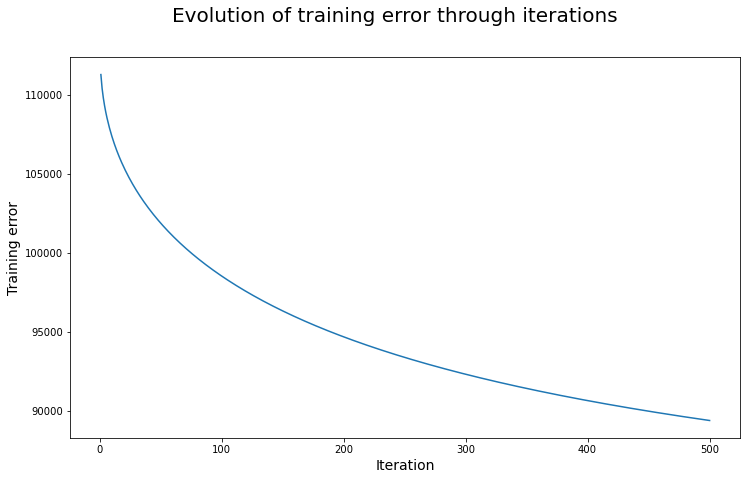

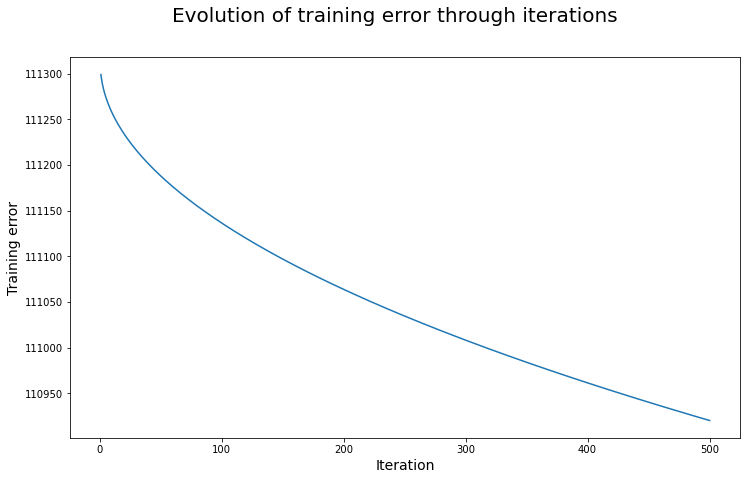

In [13]:
n_iters_params = [500]
reg_factor_params = [1e-5, 1e-10]
learn_rate_params = [0.001, 1e-5]

best_model = grid_search(parsed_train_data, parsed_val_data, n_iters_params, reg_factor_params, learn_rate_params)

In [ ]:
#01.17 17 luglio
#23.08 20 luglio

Training the model with parameters:
	Number of iterations: 1500
	Regularization factor: 1e-10         
	Learning rate: 0.01


[========================================================================] 100%


Training... DONE!
Training RMSE = 75774.41399098006
Validation RMSE = 76431.30367534744


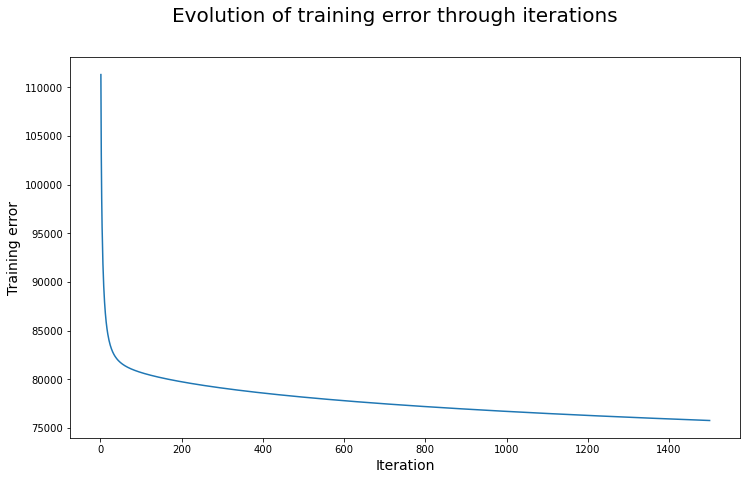

In [16]:
n_iters = 1500
learn_rate = 0.01
reg_factor = 1e-10

print('Training the model with parameters:\n\tNumber of iterations: {}\n\tRegularization factor: {} \
        \n\tLearning rate: {}'.format(n_iters, reg_factor, learn_rate))
model = RidgeRegression(n_iters = n_iters, learn_rate = learn_rate, reg_factor = reg_factor)
model.fit(parsed_train_data)
model.write_on_file()
                
print('Training... DONE!')
print('Training RMSE = {}'.format(model.train_error[-1]))

# Evaluate the model on the validation set
labels_and_preds_val = parsed_val_data.map(lambda p: model.predict_with_label(p))
rmse_val = rmse(labels_and_preds_val)

print('Validation RMSE = {}'.format(rmse_val))

plot_train_error(model)

In [6]:
n_iters = 1500
learn_rate = 0.01
reg_factor = 1e-10

model = RidgeRegression(n_iters = n_iters, learn_rate = learn_rate, reg_factor = reg_factor)

In [11]:
model.weights = DenseVector([
        4985.098658009473,
        2332.2975238180843,
        2247.4985209587267,
        513.5642314277532,
        2165.97979236329,
        2065.5783136892924,
        2492.5493290047366,
        2492.5493290047366,
        182.29324482374705,
        1307.3989196967473,
        2492.5493290047366,
        -4245.737283082123,
        842.6172959316431,
        -28.9340209778008,
        1759.341891423355,
        -140.6947034168499,
        -528.0320460557517,
        4800.751714687139,
        3733.8795561327383,
        5123.658191244818,
        4111.7239908954125,
        3075.1009449045296,
        3009.413436729139,
        7584.343644564236,
        265.91644503934293,
        1292.377966878075,
        -5517.796485721677,
        -17.523220634468494,
        1902.4818843678186,
        -4069.7798883681107,
        1432.356451639395,
        -1517.6287796498304,
        4961.730702587311,
        -38.38721812877429,
        2999.709064640478,
        -44.524062991559056,
        2492.5493290047366,
        4712.753052206058,
        -22.771989975516096,
        -90.36282744336117,
        -287.97553245929606,
        -2484.0425923812854,
        -30.256382401418882,
        1628.9630402758016,
        4464.488422207171,
        1613.5989008399106,
        2168.1411140088035,
        -2538.1395883683826,
        1772.669756322,
        393.1904327971528,
        3142.703888244738,
        532.0160687973294,
        759.7571673046708,
        -3899.021290525548,
        338.36296841602797,
        1721.2169880845804,
        1853.928151604047,
        1726.382992802742,
        -119.93844947368208,
        -630.2652356182457,
        513.1092571777313,
        2868.146485702258,
        449.15369275508743,
        517.4292494224086,
        -56.259842599278834,
        631.4339299501476,
        461.1648736090159,
        -2338.2926616489362,
        180.39651478295133,
        -59.77909351483034,
        371.9056143378574,
        4630.927974437184,
        554.4211589701216,
        -433.408299726646,
        6025.41599370797,
        2187.2691694167543,
        -3447.7888860921485,
        78.84328826347758,
        8015.023551664935,
        7528.4332762165,
        5732.916413073209,
        -2500.2048873186,
        -2816.3182428819227,
        -77.0695932425002,
        -266.9723275978654,
        -53.58404371696034,
        7.2282086793871265,
        -57.66500054066826,
        -158.42539431355044,
        2544.137387602041,
        -75.58574458113998,
        -27.179299819694275,
        61.95237445717966,
        193.36503380547902,
        192.9771508083149,
        267.69604909969064,
        193.25139975053597,
        -102.86407564788509,
        -43.316655766218624,
        -31.106032118309653,
        57.71963842942184,
        -216.9724753720696,
        107.24677499842774,
        118.41241835850616,
        99.84526405055071,
        -154.22549066164842,
        193.25139975053597,
        296.93801606528416,
        409.26578800010714,
        258.3272846256094,
        -28.332065349039286,
        -279.45013259384837,
        193.25139975053597,
        55.134008945733086,
        14.278444990442651,
        -210.77840584379462,
        -83.99606693467375,
        -149.9330942878682,
        -42.583167082959235,
        2492.5493290047366,
        193.25139975053597,
        -2.3349160218414977,
        545.7727239412385,
        86.3047755257661,
        35.86306126787072,
        6.866764566608422,
        49.67972788776873,
        -88.83688512274729,
        -80.96257542109434,
        -9.442319509213489,
        2492.5493290047366,
        -451.15621731270625,
        -41.40995763357634,
        -22.222283806821984,
        -1527.270662699285,
        563.9426379871161,
        174.33658766625882,
        488.9127248052406,
        294.28873703467855,
        759.9712215767212,
        802.5199010730746,
        936.3232033088265,
        172.3587569687111,
        245.69916245785154,
        262.99679508082534,
        209.51009626111812,
        202.45878550426968,
        185.65007507860074,
        169.35624031210057,
        640.473302960996,
        163.54457379720483,
        642.4539055388933,
        363.75924777265203,
        268.2021565931227,
        369.43120094227606,
        305.61842109867735,
        476.6800989808607,
        658.6927175544614,
        329.7100009341479,
        277.0501217089854,
        456.67631122325764,
        257.7784194167434,
        313.02400807625037,
        245.5362718420032,
        229.04757495391635,
        604.9138878347995,
        558.8273150859778,
        263.79898144719357,
        326.7410999681975,
        264.0481409489614,
        233.5257600292779,
        184.04529408647173,
        753.6102571296312,
        245.95682761429433,
        609.3048641923937,
        605.812033618197,
        178.1291550636291,
        422.5547139320912,
        322.9848020410739,
        260.91198916673227,
        1211.2041420909625,
        988.3100748290152,
        617.1080722270932,
        421.85424656997526,
        215.0120959510547,
        203.28770970293402,
        335.49527449082575,
        412.06379624794846,
        559.995505149914,
        992.3133853451959,
        140.55042984623253,
        236.05107182230265,
        169.28839782716307,
        300.7662871614751,
        317.6993580844588,
        252.36180970278545,
        326.1371730503121,
        235.10389003096407,
        399.38599913665087,
        183.26241877332387,
        436.3254243475566,
        270.30377747459755,
        199.18472335717672,
        220.15344860849157,
        144.20164335164304,
        164.0611818914943,
        993.6871984546867,
        183.09430996273014,
        436.31048501675497,
        231.60885020286486,
        155.16057307385148,
        177.56789592681662,
        148.10850389867554,
        163.8011708378091,
        574.5445026742672
    ])

In [16]:
out = 20

for i in range(out):
    predictions_and_labels = (model.predict_with_label(parsed_train_data.take(out)[i], weights = model.weights))
    print((int)(real_label(predictions_and_labels[0])), (int)(predictions_and_labels[1]))

9600 48501
31700 64705
12700 47928
50000 80816
39900 83835
17300 82441
30400 71780
34000 77444
31700 61497
73300 63873
87000 56587
54000 75640
59250 78878
22000 74742
31000 62432
187900 85943
180050 80363
11100 45446
72300 76690
3200 69961
